# Get traffic sign features

In [1]:
import json
import requests

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

import seaborn as sns
import folium

import functions as f

import config_azure as cf

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_9814/3720848546.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS d

In [2]:
os.system('sudo blobfuse /home/azureuser/cloudfiles/code/blobfuse/sidewalk --tmp-path=/mnt/resource/blobfusetmp --config-file=/home/azureuser/cloudfiles/code/blobfuse/fuse_connection_sidewalk.cfg -o attr_timeout=3600 -o entry_timeout=3600 -o negative_timeout=3600 -o allow_other -o nonempty')

0

### Settings

In [3]:
CRS = 'epsg:28992'

In [4]:
# Input paths
#https://data.amsterdam.nl/datasets/AlrMVAnBaUNb-w/verkeersborden/?term=Verkeersborden
signs_file = '2022juni_verkeersborden_obv_beeldherkenning.csv'

### Functions

In [5]:
def subset_data(df, df_loc):
    df_sub = gpd.sjoin(df, df_loc.set_geometry('buffer'), how='inner').reset_index()
    df_sub = df_sub.rename(columns = {'geometry_left': 'geometry'})
    df_sub = df_sub.set_geometry('geometry')
    return df_sub

## 1. Get traffic sign data

In [6]:
df_signs_all = pd.read_csv(signs_file)
df_signs_all = GeoDataFrame(df_signs_all, geometry=gpd.points_from_xy(df_signs_all['x-coordinaat'], 
                                                                      df_signs_all['y-coordinaat']), crs=CRS)
df_signs_all = df_signs_all.drop(['x-coordinaat', 'y-coordinaat'], axis=1)

/tmp/ipykernel_9814/4277714923.py:1: DtypeWarning: Columns (6,7,12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_signs_all = pd.read_csv(signs_file)


### Select crosswalk traffic signs

In [7]:
#L02(F): Voetgangers oversteekplaats / zebrapad (blauw)
#J22(F): Voetgangersoversteekplaats met een zebrapad (vooraanduiding)  (rood)
#J23(F): U nadert een niet gemarkeerde voetgangers oversteekplaats

df_signs = df_signs_all[df_signs_all['rvv-modelnummer'].isin(['J22', 'J22F',
                                                              'L02', 'L02F', 'L02OB15F'])].reset_index(drop=True)
df_signs = df_signs.dropna(axis=1, how='all')  # remove columns without values

### Get mask of area

200


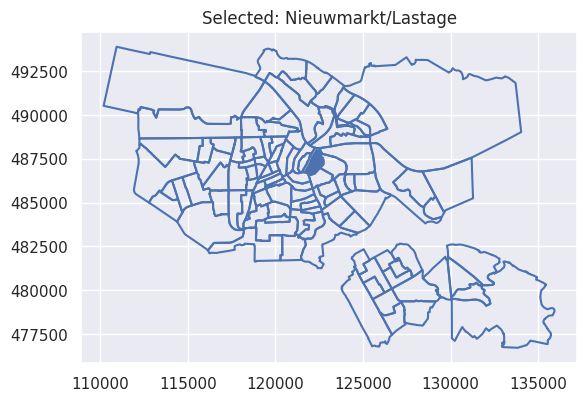

In [8]:
# Pull polygon of area for which to gather curb segments

# Select area granularity (buurten/wijken/ggwgebieden/stadsdelen, https://api.data.amsterdam.nl/v1/docs/datasets/gebieden.html)
area_granularity = 'wijken'

# SELECT AREA
district_name = 'Centrum'
my_area = 'Nieuwmarkt/Lastage'
# district_name = 'Nieuw-West'
# my_area = 'Osdorp-Midden'

# Get area data
area_url = "https://api.data.amsterdam.nl/v1/gebieden/" + area_granularity
response_area = requests.get(url = area_url, params = {"_pageSize": 1000})
raw_data_area = response_area.json()['_embedded']
print(response_area.status_code)

# Create a proper GeoDataFrame with the area data
gdf_area = f.create_area_gdf(raw_data_area)
gdf_area_sel = gdf_area[gdf_area['naam'] == my_area]
area_polygon = gdf_area_sel.iloc[0]['geometry']

sns.set()
ax = gdf_area.boundary.plot()
ax = gdf_area_sel.plot(ax=ax)
plt.title('Selected: {}'.format(my_area))
plt.show()

### Extract traffic sign information in polygon of area

In [9]:
tl_data_in_area_mask = area_polygon.contains(df_signs['geometry'])
tl_data_in_area = df_signs.loc[tl_data_in_area_mask]
tl_data_in_area = tl_data_in_area.to_crs("EPSG:4326")

### Inspect data

In [10]:
if tl_data_in_area.empty:
    print('No sidewalk data available in area')

tl_data_in_area

,id,bord id,rvv-modelnummer,ondersteuningsconstructie id,ondersteuningsconstructie type,straatnaam,wegnummer,hoogte onderkant bord,kijkrichting,laatste aanpassing,plaatsingsdatum,type plaatsing,in function,geometry
1224,68408,9252365,L02,8337282,Flespaal,Jodenbreestraat,NaN,2.48,305,2021-11-29 11:40:58,4-8-2016,Permanent,Yes,POINT (4.90232 52.36914)
1238,69571,9255441,L02,8339235,Flespaal,Uilenburgersteeg,NaN,1.9,215,2022-05-31 12:43:47,15-8-2016,Permanent,Yes,POINT (4.90250 52.36923)
1239,69585,9255452,J22,8339242,Flespaal,Prins Hendrikkade,NaN,2.62,232,2021-11-29 11:26:53,3-8-2016,Permanent,Yes,POINT (4.90324 52.37544)
1240,69586,9255454,J22,8339244,Flespaal,Prins Hendrikkade,NaN,2.82,165,2021-11-29 11:26:53,3-8-2016,Permanent,Yes,POINT (4.90336 52.37544)
1241,69903,9256065,L02,8339501,Flespaal,Jodenbreestraat,NaN,2.45,305,2021-11-29 11:32:51,15-8-2016,Permanent,Yes,POINT (4.90262 52.36904)
1243,70058,9256356,L02,8339704,Flespaal,Uilenburgersteeg,NaN,2.78,35,2021-11-29 11:55:22,15-8-2016,Permanent,Yes,POINT (4.90256 52.36911)
1246,70062,9256361,L02,8339709,Flespaal,Houtkopersdwarsstraat,NaN,2.45,220,2021-11-29 11:37:19,4-8-2016,Permanent,Yes,POINT (4.90249 52.36901)
1252,70069,9256373,L02,8339721,Flespaal,Waterlooplein,NaN,2.6,80,2021-11-29 11:26:23,15-8-2016,Permanent,Yes,POINT (4.90252 52.36729)
1254,70071,9256377,L02,8339725,Flespaal,Muiderstraat,NaN,2.41,127,2021-11-29 11:26:28,15-8-2016,Permanent,Yes,POINT (4.90508 52.36798)
1257,70074,9256382,L02,8339730,Flespaal,Muiderstraat,NaN,2.64,303,2021-11-29 11:26:25,15-8-2016,Permanent,Yes,POINT (4.90520 52.36804)


## 2. Check traffic signs data

### Plot traffic signs data on html map 

In [11]:
# Select area coordinates
area_coords_dict = {
'Oost': [52.35841459492269, 4.94096580861934], 
'Zuidoost': [52.30835541646421, 4.971026316183298],
'Centrum': [52.37264632447709, 4.900686689681244],
'West': [52.375664816888225, 4.8632280955697995],
'Nieuw-West': [52.36136534992387, 4.804764163088018],
'Westpoort': [52.40782411314917, 4.812262034376182],
'Noord': [52.40187730790636, 4.93238933578444],
'Zuid': [52.342595766801054, 4.878187302708811]
}
area_coords = area_coords_dict[district_name]

# Create tooltip for feature representation on map
def gen_tooltip(fields, aliases):

    tooltip = folium.GeoJsonTooltip(
        fields=fields,
        aliases=aliases,
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )
    return tooltip

# set True for satelite background, False for regular background
satelite = False

# Set folium map background
if satelite == True:
    network_color = 'white'
    tile = folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)
else:
    tile = 'openstreetmap'
    network_color = 'black'

# Create Folium map
map = folium.Map(
    location=area_coords, tiles=tile,
    min_zoom=10, max_zoom=25, zoom_start=15,
    zoom_control=True, control_scale=True, control=False
    )

# Add traffic sign features
feature_names = tl_data_in_area.columns.tolist()
feature_names.remove('geometry')
tooltip = gen_tooltip(feature_names, feature_names)
geo_j = folium.GeoJson(tl_data_in_area, tooltip=tooltip, style_function=lambda x: {"color": "orange", "weight": 10}).add_to(map)

map

### Save features as csv and html map

In [12]:
# Save traffic sign crossing features as csv
tl_data_in_area.to_csv(cf.out_folder + '/crossing_features/traffic_sign/crossing_features_traffic_sign_{}.csv'.format(my_area.replace('/', '-')))

# Save network with traffic sign crossing features as html map
if satelite == True:
    map.save(cf.out_folder + '/crossing_features/traffic_sign/crossing_features_traffic_sign_' + my_area.replace('/', '-') + '_satelite.html')
else:
    map.save(cf.out_folder + '/crossing_features/traffic_sign/crossing_features_traffic_sign_' + my_area.replace('/', '-') + '.html')